In [15]:
# %load imports.ipy
# Stdlib
from functools import partial
from itertools import chain
from pprint import pprint as print

import numpy as np
import pandas as pd

pd.set_option('display.max_columns',102)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width',120)
import sklearn
print(f'numpy {np.__version__} pandas {pd.__version__} sklearn {sklearn.__version__}')

# Visualization

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

custom_style = {'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white', }
sns.set_style( rc=custom_style)
mpl.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.figsize']=(10,10)
jtplot.style('monokai')
# Custom stuff
from swozny_ml import *
from genetic.parameter_optimization import tune_params_genetic


'numpy 1.13.3 pandas 0.20.3 sklearn 0.19.0'


In [2]:
# %load classify.py
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_val_score

from genetic.estimator_parameters import params
from genetic.parameter_optimization import tune_params_genetic
from swozny_ml import benchmark_models, tune_params

# Config

In [3]:
filename = 'datasets/kobe_preprocessed.csv'
index = 'shot_id'
target = 'shot_made_flag'
prediction_params = ['Angle', 'Distance']
scoring = 'neg_log_loss'
voting = 'soft'

# Read data

In [4]:
data = pd.read_csv(filename, index_col=index)
print(data.head())

         action_type_0  action_type_1  action_type_2  action_type_3  action_type_4  action_type_5  action_type_6  \
shot_id                                                                                                            
1        1              0              0              0              0              0              0               
2        1              0              0              0              0              0              0               
3        1              0              0              0              0              0              0               
4        1              0              0              0              0              0              0               
5        0              0              0              0              0              0              0               

         action_type_7  action_type_8  action_type_9  minutes_remaining_2  minutes_remaining_3  minutes_remaining_4  \
shot_id                                                             

# Prepare data

In [5]:
training_cond = data[target].notnull()
X_train = data[training_cond].drop(target,axis=1)#[prediction_params]
y_train = data[training_cond][target]

# Benchmark different estimators

In [6]:
classifiers = [estimator for estimator in params if "Classifier" in estimator.__name__] + [LogisticRegression]
benchmark = benchmark_models(classifiers, X_train, y_train, scoring=scoring)

Evaluating AdaBoostClassifier                       ... Score -0.69
Evaluating BaggingClassifier                        ... Score -1.25
Evaluating DecisionTreeClassifier                   ... Score -3.46
Evaluating ExtraTreeClassifier                      ... Score -3.40
Evaluating ExtraTreesClassifier                     ... Score -2.30
Evaluating GradientBoostingClassifier               ... Score -0.61
Evaluating XGBClassifier                            ... Score -0.61
Evaluating KNeighborsClassifier                     ... Score -2.27
Evaluating PassiveAggressiveClassifier              ...

/home/swozny/untitled5/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


 failed
Evaluating RandomForestClassifier                   ... Score -1.30
Evaluating RidgeClassifier                          ... failed
Evaluating SGDClassifier                            ...

/home/swozny/untitled5/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


 failed
Evaluating LogisticRegression                       ... Score -0.61


# Report estimator performances

                                                                 Algorithm      Mean       Std
9  <class 'sklearn.linear_model.logistic.LogisticRegression'>              -0.611253  0.011136
5  <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> -0.611128  0.009132
6  <class 'xgboost.sklearn.XGBClassifier'>                                 -0.610400  0.008917


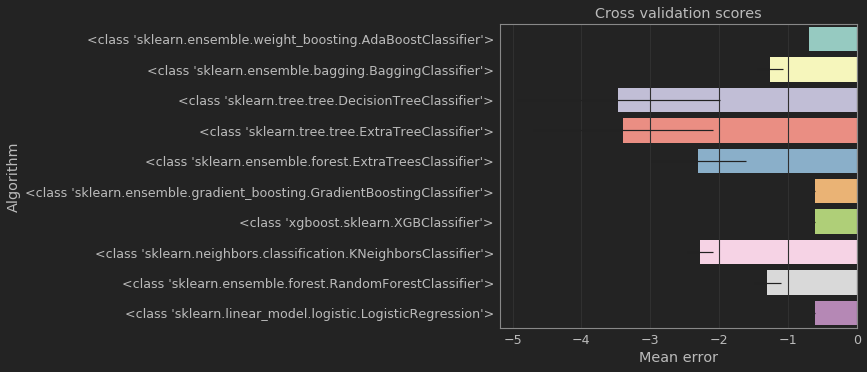

In [7]:
plot_benchmark(benchmark)
considered_algorithms = benchmark.sort_values('Mean').tail(3)
print(considered_algorithms)

# Tune the best estimators

In [8]:
if True:
    tuned = tune_params(considered_algorithms['Algorithm'], X_train, y_train, scoring=scoring)
else:
    tuned = tune_params_genetic(considered_algorithms['Algorithm'], X_train, y_train, scoring=scoring)

Tuning LogisticRegression with {'C': array([ 0.1       ,  0.31111111,  0.52222222,  0.73333333,  0.94444444,
        1.15555556,  1.36666667,  1.57777778,  1.78888889,  2.        ])}...
-0.611247003727
Tuning GradientBoostingClassifier with {'learning_rate': [0.01, 0.1], 'n_estimators': [10, 100]}...
-0.611161353228
Tuning XGBClassifier with {'learning_rate': [0.1, 0.01], 'max_depth': [3, 5, 7], 'n_estimators': [10, 30, 50, 70]}...
-0.610752551643


# Calibrate the tuned estimators

In [9]:
calibrated = [CalibratedClassifierCV(model).fit(X_train, y_train) for model in tuned]

# Show Correlation between estimators

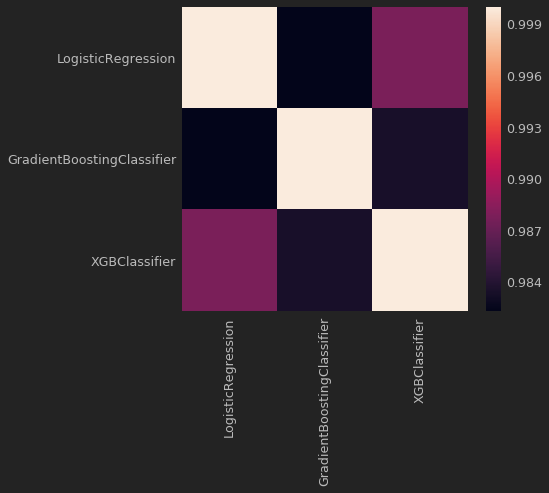

In [10]:
predictions = pd.concat(
    [pd.Series(model.predict(X_train), name=type(model.base_estimator).__name__) for model in calibrated], axis=1)
sns.heatmap(predictions.corr())

# Create an ensemble

In [11]:
ensemble_model = VotingClassifier([(type(model.base_estimator).__name__, model) for model in calibrated], voting=voting)

# Predict

In [12]:
score = cross_val_score(ensemble_model, X=X_train, y=y_train,scoring=scoring)
print(f"Final cross validation score is {score}")

'Final cross validation score is [-0.60479232 -0.61484325 -0.60932238]'


# Confusion

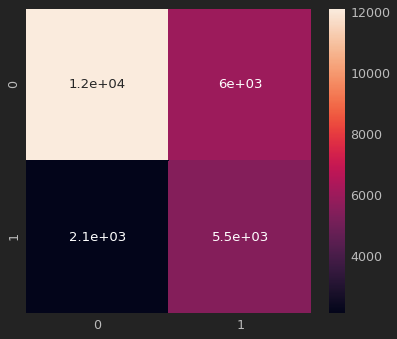

In [13]:
ensemble_model.fit(X_train, y_train)
sns.heatmap(confusion_matrix(ensemble_model.predict(X_train), y_train), annot=True)

# Generate output

In [14]:
test_cond = ~training_cond
X_test = data[test_cond].drop(target,axis=1)#[prediction_params]
y_pred = ensemble_model.predict_proba(X_test)
X_test['shot_made_flag'] = y_pred[:, 1]
X_test.shot_made_flag.to_csv('pred_kobe.csv', header=True)